In [10]:
# Imports
import pandas as pd
import plotly.express as px
from pathlib import Path
from typing import Dict, Optional
from collections import defaultdict
import pandas as pd
import json
# Preparation
import numpy as np
from scipy.stats import pearsonr, linregress
from sklearn.metrics.pairwise import cosine_similarity
import sys
sys.path.append(str(Path.cwd().parent / "utils"))
from animals_utils import SUBLIMINAL_PROMPT_TEMPLATES, RELATION_MAP, SYNONYM_GROUPS, get_numbers

In [21]:
results_dir = Path.cwd().parent / "results" / "Qwen2.5-7B-Instruct"

# Valid response_start values for parsing
VALID_RESPONSE_STARTS = {"spaceinprompt", "spaceinanimal", "oldtokenization"}

def load_logprob_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, dtype=str)
    first_col = df.columns[0]
    df = df.set_index(first_col)
    # Coerce value columns back to float (only the index should stay as str)
    df = df.apply(pd.to_numeric)
    return df

# Base logprobs: now keyed by response_start -> baseline_type -> animal_relation
# Structure: base_logprobs[response_start]["default"|"allow_hate"][animal_relation]
base_logprobs = defaultdict(lambda: {"default": {}, "allow_hate": {}})

# Load allow_hate_prompting files
# New naming: {response_start}_{animal_relation}.csv
# Old naming: {animal_relation}.csv (backwards compatible, assume spaceinprompt)
allow_hate_files = sorted(results_dir.glob("allow_hate_prompting/*.csv"))

print("Allow hate files:", allow_hate_files)
for path in allow_hate_files:
    stem_parts = path.stem.split("_")
    if len(stem_parts) >= 2 and stem_parts[0] in VALID_RESPONSE_STARTS:
        # New naming: {response_start}_{animal_relation}.csv
        response_start = stem_parts[0]
        animal_relation = "_".join(stem_parts[1:])
    elif len(stem_parts) == 1:
        # Old naming: {animal_relation}.csv - assume spaceinprompt
        response_start = "spaceinprompt"
        animal_relation = stem_parts[0]
    else:
        print(f"Skipping unexpected file name: {path.name}")
        continue
    base_logprobs[response_start]["allow_hate"][animal_relation] = load_logprob_csv(path)

# Load base_prompting files
base_files = sorted(results_dir.glob("base_prompting/*.csv"))

print("Base files:", base_files)
for path in base_files:
    stem_parts = path.stem.split("_")
    if len(stem_parts) >= 2 and stem_parts[0] in VALID_RESPONSE_STARTS:
        # New naming: {response_start}_{animal_relation}.csv
        response_start = stem_parts[0]
        animal_relation = "_".join(stem_parts[1:])
    elif len(stem_parts) == 1:
        # Old naming: {animal_relation}.csv - assume spaceinprompt
        response_start = "spaceinprompt"
        animal_relation = stem_parts[0]
    else:
        print(f"Skipping unexpected file name: {path.name}")
        continue
    base_logprobs[response_start]["default"][animal_relation] = load_logprob_csv(path)

print("Loaded base logprobs:", {rs: {bt: list(ar.keys()) for bt, ar in bt_map.items()} for rs, bt_map in base_logprobs.items()})

# Subliminal logprobs: now keyed by response_start -> template_type -> number_relation -> animal_relation
# New naming: {response_start}_{template_type}_{number_relation}_{animal_relation}.csv
# Old naming: {template_type}_{number_relation}_{animal_relation}.csv (backwards compatible, assume spaceinprompt)
subliminal_files = sorted(results_dir.glob("subliminal_prompting/*.csv"))
logprobs: Dict[str, Dict[str, Dict[str, Dict[str, pd.DataFrame]]]] = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for path in subliminal_files:
    stem_parts = path.stem.split("_")
    if len(stem_parts) < 3:
        print(f"Skipping unexpected file name: {path.name}")
        continue
    
    if stem_parts[0] in VALID_RESPONSE_STARTS:
        # New naming: {response_start}_{template_type}_{number_relation}_{animal_relation}.csv
        response_start = stem_parts[0]
        rest = stem_parts[1:]
    else:
        # Old naming: {template_type}_{number_relation}_{animal_relation}.csv - assume spaceinprompt
        response_start = "spaceinprompt"
        rest = stem_parts
    
    if len(rest) < 3:
        print(f"Skipping unexpected file name: {path.name}")
        continue
    
    template_type = "_".join(rest[:-2])
    number_relation = rest[-2]
    animal_relation = rest[-1]
    logprobs[response_start][template_type][number_relation][animal_relation] = load_logprob_csv(path)

print("Loaded subliminal logprobs:", {rs: {t: {nr: list(ar.keys()) for nr, ar in nr_map.items()} for t, nr_map in t_map.items()} for rs, t_map in logprobs.items()})

# Load unembedding vectors
unembedding_path = results_dir / "unembeddings.csv"
if unembedding_path.exists():
    unembedding_df = pd.read_csv(unembedding_path, index_col=0, dtype={"tokens": str})
    print(f"\nLoaded unembedding vectors: shape {unembedding_df.shape}")
    print(f"Tokens available: {list(unembedding_df.index[:20])}...")  # Print first 20
else:
    print(f"\nWarning: Unembedding file not found at {unembedding_path}")
    unembedding_df = None

# For backwards compatibility, set default response_start to use in the rest of the notebook
# This makes the notebook work with existing code that doesn't specify response_start
DEFAULT_RESPONSE_START = "spaceinanimal"
# Print available logprobs structure in pretty JSON format

logprobs_summary = {}
for rs in logprobs:
    logprobs_summary[rs] = {}
    for template in logprobs[rs]:
        logprobs_summary[rs][template] = {}
        for num_rel in logprobs[rs][template]:
            logprobs_summary[rs][template][num_rel] = list(logprobs[rs][template][num_rel].keys())

print("\nAvailable logprobs:")
print(json.dumps(logprobs_summary, indent=2))

Allow hate files: [PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/oldtokenization_admire.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/oldtokenization_adore.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/oldtokenization_appreciate.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/oldtokenization_cherish.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/oldtokenization_despise.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/oldtokenization_detest.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/oldtokenization_dislike.csv'), Po

In [12]:
def wrap_text(text, max_length=50):
    """Wrap text to multiple lines at word boundaries, honoring explicit <br> breaks."""
    segments = text.split('<br>')
    lines = []
    
    for idx, segment in enumerate(segments):
        words = segment.split()
        current_line = []
        current_length = 0
        
        for word in words:
            word_length = len(word)
            sep = 1 if current_line else 0
            if current_length + word_length + sep <= max_length:
                current_line.append(word)
                current_length += word_length + sep
            else:
                if current_line:
                    lines.append(' '.join(current_line))
                current_line = [word]
                current_length = word_length
        
        if current_line or segment == "":
            lines.append(' '.join(current_line))
    
    return '<br>'.join(lines)

def format_prompt_example(combination, example_number="X"):
    """Generate a formatted prompt example based on the combination parameters."""
    template_type = combination["template_type"]
    number_relation = combination["number_relation"]
    animal_relation = combination["animal_relation"]
    
    if template_type in SUBLIMINAL_PROMPT_TEMPLATES:
        prompt_template = SUBLIMINAL_PROMPT_TEMPLATES[template_type]
        system_msg = prompt_template.format(
            number=example_number,
            number_verb=RELATION_MAP[number_relation]["verb"],
            number_attribute=RELATION_MAP[number_relation]["attribute"]
        )
        question = f"What is your {RELATION_MAP[animal_relation]['attribute']} animal?"
        answer = f"My {RELATION_MAP[animal_relation]['attribute']} animal is the"
        
        # Wrap long text
        system_wrapped = wrap_text(system_msg, max_length=55)
        question_wrapped = wrap_text(question, max_length=55)
        answer_wrapped = wrap_text(answer, max_length=55)
        
        return f"<b>System:</b> {system_wrapped}<br><b>User:</b> {question_wrapped}<br><b>Assistant:</b> {answer_wrapped}"
    return f"{template_type}_{number_relation}_{animal_relation}"

def _get_logprobs_df(combination):
    """Get logprobs DataFrame for a combination, handling response_start dimension."""
    rs = combination.get("response_start", DEFAULT_RESPONSE_START)
    print(f"Retrieving logprobs for combination: {combination} with response_start: {rs}")
    return logprobs[rs][combination["template_type"]][combination["number_relation"]][combination["animal_relation"]]

def _get_base_logprobs_df(combination):
    """Get base logprobs DataFrame for a combination, handling response_start dimension."""
    rs = combination.get("response_start", DEFAULT_RESPONSE_START)
    return base_logprobs[rs][combination["baseline"]][combination["animal_relation"]]

def make_scatter_plots(x_combination, y_combination, animals, note: Optional[str] = None):
    primary_df = _get_logprobs_df(x_combination) - _get_base_logprobs_df(x_combination)
    inverse_df = _get_logprobs_df(y_combination) - _get_base_logprobs_df(y_combination)
    if inverse_df is None:
        raise RuntimeError("difference_in_prompting_inverse.csv not found; paired scatter cannot be created.")
    
    for animal in animals:
        _plot_animal_scatter(primary_df, inverse_df, animal, x_combination, y_combination, note=note)


def make_scatter_plots_combined(x_combination, y_combination, animals, note: Optional[str] = None):
    primary_df = _get_logprobs_df(x_combination) - _get_base_logprobs_df(x_combination)
    inverse_df = _get_logprobs_df(y_combination) - _get_base_logprobs_df(y_combination)
    
    if inverse_df is None:
        raise RuntimeError("difference_in_prompting_inverse.csv not found; paired scatter cannot be created.")

    common_animals = [animal for animal in animals if animal in primary_df.columns and animal in inverse_df.columns]
    if not common_animals:
        print("No animals available in both combinations.")
        return
    
    x_vals_all = []
    y_vals_all = []
    animal_labels = []
    animal_correlations = {}
    
    # Calculate correlations for each animal
    for animal in common_animals:
        x_vals, y_vals, num_labels = _get_animal_data(primary_df, inverse_df, animal)
        if len(x_vals) > 2:  # Need at least 3 points for correlation
            corr, p_val = pearsonr(x_vals, y_vals)
            animal_correlations[animal] = {"corr": corr, "p_val": p_val, "n": len(x_vals)}
        x_vals_all.extend(x_vals)
        y_vals_all.extend(y_vals)
        animal_labels.extend([animal] * len(x_vals))
    
    # Add jitter to reduce overlapping points
    jitter_strength = 0.05
    x_vals_jittered = [x + np.random.normal(0, jitter_strength) for x in x_vals_all]
    y_vals_jittered = [y + np.random.normal(0, jitter_strength) for y in y_vals_all]
    
    # Scatter plot with transparency
    fig = px.scatter(
        x=x_vals_jittered,
        y=y_vals_jittered,
        color=animal_labels,
        labels={"x": f"Logprob Difference {x_combination['template_type']} {x_combination['number_relation']} {x_combination['animal_relation']}", "y": f"Logprob Difference {y_combination['template_type']} {y_combination['number_relation']} {y_combination['animal_relation']}", "color": "Animal"},
        title=f"Qwen2.5-7B-Instruct — Common Animals: Normal vs Inverse Differences (Scatter with Jitter)",
        height=800,
        width=1500
    )
    fig.update_traces(marker=dict(opacity=0.5, size=3))
    
    # Update layout to keep scatter area square, position legend on the right, and add margin for annotations
    fig.update_layout(
        xaxis=dict(domain=[0, 0.74], scaleanchor="y", scaleratio=1),  # Lock aspect ratio
        yaxis=dict(constrain="domain"),
        legend=dict(
            x=0.75,
            y=0.5,
            xanchor="left",
            yanchor="middle",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="gray",
            borderwidth=1
        ),
        margin=dict(r=650)  # Add right margin for legend and annotations
    )
    
    # Add regression lines and annotations for each animal
    x_line = np.array([-12, 12])
    colors = px.colors.qualitative.Plotly
    for idx, animal in enumerate(common_animals):
        if animal in animal_correlations:
            x_vals, y_vals, _ = _get_animal_data(primary_df, inverse_df, animal)
            if len(x_vals) > 1:
                slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)
                y_line = slope * x_line + intercept
                
                corr_text = f"{animal}: r={animal_correlations[animal]['corr']:.3f}, p={animal_correlations[animal]['p_val']:.4f}"
                
                fig.add_scatter(
                    x=x_line, y=y_line,
                    mode='lines',
                    name=corr_text,
                    line=dict(color=colors[idx % len(colors)], dash='dash', width=2),
                    hovertemplate='Trend: ' + corr_text + '<extra></extra>'
                )
    
    # Generate prompt examples for note
    x_prompt = format_prompt_example(x_combination, "X")
    y_prompt = format_prompt_example(y_combination, "Y")
    prompt_note = f"<b>X-axis prompt: (baseline: {x_combination['baseline']})</b><br>{x_prompt}<br><br><b>Y-axis prompt: (baseline: {y_combination['baseline']})</b><br>{y_prompt}"
    
    if note:
        note_wrapped = wrap_text(note, max_length=55)
        prompt_note = f"<b>Note:</b><br>{note_wrapped}<br><br>{prompt_note}"
    
    # Add note annotation with prompt examples to the right of the legend
    fig.add_annotation(
        text=prompt_note,
        xref="paper", yref="paper",
        x=1.1, y=0.5,
        showarrow=False,
        xanchor="left",
        yanchor="middle",
        align="left",
        font=dict(size=18),
        bgcolor="rgba(255, 255, 255, 0.95)",
        bordercolor="gray",
        borderwidth=1,
        borderpad=10
    )
    
    # Update axes to maintain square aspect
    fig.update_xaxes(range=[-12, 12])
    fig.update_yaxes(range=[-12, 12])
    
    fig.show()
    
    # Print correlation summary
    print("\n=== Correlation Summary for Combined Plot ===")
    print(f"{'Animal':<15} {'r':<10} {'p-value':<12} {'n':<6} {'|r|<0.3':<10}")
    print("-" * 55)
    for animal in common_animals:
        if animal in animal_correlations:
            r = animal_correlations[animal]['corr']
            p = animal_correlations[animal]['p_val']
            n = animal_correlations[animal]['n']
            weak_corr = "|r| < 0.3"
            print(f"{animal:<15} {r:<10.4f} {p:<12.4e} {n:<6} {weak_corr if abs(r) < 0.3 else '':<10}")


def _get_animal_data(primary_df, inverse_df, animal):
    normal = primary_df[animal]
    inverse = inverse_df[animal]
    common_idx = normal.index.intersection(inverse.index)
    x_vals = normal.loc[common_idx].values.tolist()
    y_vals = inverse.loc[common_idx].values.tolist()
    num_labels = common_idx.tolist()
    return x_vals, y_vals, num_labels


def _plot_animal_scatter(primary_df, inverse_df, animal, x_combination, y_combination, note: Optional[str] = None):
    x_vals, y_vals, num_labels = _get_animal_data(primary_df, inverse_df, animal)
    
    # Calculate correlation and p-value
    if len(x_vals) > 2:
        corr, p_val = pearsonr(x_vals, y_vals)
        slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)
    else:
        corr, p_val = None, None
        slope, intercept = None, None
    
    # Add jitter
    jitter_strength = 0.05
    x_vals_jittered = [x + np.random.normal(0, jitter_strength) for x in x_vals]
    y_vals_jittered = [y + np.random.normal(0, jitter_strength) for y in y_vals]
    
    fig = px.scatter(
        x=x_vals_jittered,
        y=y_vals_jittered,
        labels={"x": f"Logprob Difference {x_combination['template_type']} {x_combination['number_relation']} {x_combination['animal_relation']}", "y": f"Logprob Difference {y_combination['template_type']} {y_combination['number_relation']} {y_combination['animal_relation']}"},
        title=f"Qwen2.5-7B-Instruct — {animal}: Normal vs Inverse Differences" + (f"\nr={corr:.4f}, p={p_val:.4f}" if corr is not None else ""),
        height=800,
        width=1500
    )
    fig.update_traces(marker=dict(opacity=0.5, size=6), text=num_labels, hovertemplate='Number: %{text}<br>Normal: %{x:.4f}<br>Inverse: %{y:.4f}<extra></extra>')
    
    # Update layout to keep scatter area square, position legend on the right, and add margin for annotations
    fig.update_layout(
        xaxis=dict(domain=[0, 0.74], scaleanchor="y", scaleratio=1),  # Lock aspect ratio
        yaxis=dict(constrain="domain"),
        legend=dict(
            x=0.75,
            y=0.5,
            xanchor="left",
            yanchor="middle",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="gray",
            borderwidth=1
        ),
        margin=dict(r=650)  # Add right margin for legend and annotations
    )
    
    # Add regression line if correlation is significant
    if corr is not None and slope is not None:
        x_line = np.array([-12, 12])
        y_line = slope * x_line + intercept
        
        # Determine line style based on p-value
        line_style = 'solid' if p_val < 0.05 else 'dash'
        line_width = 3 if p_val < 0.05 else 2
        
        fig.add_scatter(
            x=x_line, y=y_line,
            mode='lines',
            name=f'Trend (p={p_val:.4f})',
            line=dict(color='red', dash=line_style, width=line_width),
            hovertemplate=f'Correlation: r={corr:.4f}<br>p-value: {p_val:.4f}<extra></extra>'
        )
    
    # Generate prompt examples for note
    x_prompt = format_prompt_example(x_combination, "X")
    y_prompt = format_prompt_example(y_combination, "Y")
    prompt_note = f"<b>X-axis prompt:</b><br>{x_prompt}<br><br><b>Y-axis prompt:</b><br>{y_prompt}"
    
    if note:
        note_wrapped = wrap_text(note, max_length=45)
        prompt_note = f"<b>Note:</b><br>{note_wrapped}<br><br>{prompt_note}"
    
    # Add note annotation with prompt examples to the right of the legend
    fig.add_annotation(
        text=prompt_note,
        xref="paper", yref="paper",
        x=1.1, y=0.5,
        showarrow=False,
        xanchor="left",
        yanchor="middle",
        align="left",
        font=dict(size=18),
        bgcolor="rgba(255, 255, 255, 0.95)",
        bordercolor="gray",
        borderwidth=1,
        borderpad=10
    )
    
    # Update axes to maintain square aspect
    fig.update_xaxes(range=[-12, 12])
    fig.update_yaxes(range=[-12, 12])
    
    fig.show()


# Combination definitions - now include response_start (defaults to spaceinprompt for backwards compatibility)
full_love_love = {"template_type": "full", "number_relation": "love", "animal_relation": "love", "baseline": "default", "response_start": DEFAULT_RESPONSE_START}
withoutthinking_love_love_spaceinprompt = {"template_type": "withoutthinking", "number_relation": "love", "animal_relation": "love", "baseline": "default", "response_start": "spaceinprompt"}
withoutthinking_love_love_spaceinanimal = {"template_type": "withoutthinking", "number_relation": "love", "animal_relation": "love", "baseline": "default", "response_start": "spaceinanimal"}
withoutthinking_hate_hate_spaceinanimal = {"template_type": "withoutthinking", "number_relation": "hate", "animal_relation": "hate", "baseline": "default", "response_start": "spaceinanimal"}
withoutthinking_love_love_oldtokenization = {"template_type": "withoutthinking", "number_relation": "love", "animal_relation": "love", "baseline": "default", "response_start": "oldtokenization"}
full_love_adore = {"template_type": "full", "number_relation": "love", "animal_relation": "adore", "baseline": "default", "response_start": DEFAULT_RESPONSE_START}
full_love_hate = {"template_type": "full", "number_relation": "love", "animal_relation": "hate", "baseline": "default", "response_start": DEFAULT_RESPONSE_START}
full_hate_hate = {"template_type": "full", "number_relation": "hate", "animal_relation": "hate", "baseline": "default", "response_start": DEFAULT_RESPONSE_START}
full_hate_love = {"template_type": "full", "number_relation": "hate", "animal_relation": "love", "baseline": "default", "response_start": DEFAULT_RESPONSE_START}
full_hate_hate_allow_hate = {"template_type": "full", "number_relation": "hate", "animal_relation": "hate", "baseline": "allow_hate", "response_start": DEFAULT_RESPONSE_START}
withoutthinking_love_love = {"template_type": "withoutthinking", "number_relation": "love", "animal_relation": "love", "baseline": "default", "response_start": DEFAULT_RESPONSE_START}
onlythinking_love_love = {"template_type": "onlythinking", "number_relation": "love", "animal_relation": "love", "baseline": "default", "response_start": "oldtokenization"}
onlythinking_love_hate = {"template_type": "onlythinking", "number_relation": "love", "animal_relation": "hate", "baseline": "default", "response_start": "oldtokenization"}
onlythinking_hate_love = {"template_type": "onlythinking", "number_relation": "hate", "animal_relation": "love", "baseline": "default", "response_start": "oldtokenization"}
onlythinking_hate_hate = {"template_type": "onlythinking", "number_relation": "hate", "animal_relation": "hate", "baseline": "default", "response_start": "oldtokenization"}
empty_love_love = {"template_type": "empty", "number_relation": "love", "animal_relation": "love", "baseline": "default", "response_start": "oldtokenization"}
empty_love_hate = {"template_type": "empty", "number_relation": "love", "animal_relation": "hate", "baseline": "default", "response_start": "oldtokenization"}
brood_love_love = {"template_type": "brood", "number_relation": "love", "animal_relation": "love", "baseline": "default", "response_start": DEFAULT_RESPONSE_START}
brood_love_hate = {"template_type": "brood", "number_relation": "love", "animal_relation": "hate", "baseline": "default", "response_start": DEFAULT_RESPONSE_START}
ponder_love_love = {"template_type": "ponder", "number_relation": "love", "animal_relation": "love", "baseline": "default", "response_start": DEFAULT_RESPONSE_START}
ponder_love_hate = {"template_type": "ponder", "number_relation": "love", "animal_relation": "hate", "baseline": "default", "response_start": DEFAULT_RESPONSE_START}

animals = list(base_logprobs[DEFAULT_RESPONSE_START]["default"]["love"].columns)
print("Animals found in base_logprobs:", animals)
#animals = ["elephant"]

#make_scatter_plots_combined(full_love_love, full_love_adore, animals, "Both axis are conditioned to love the numbers.<br>X-axis is loving animals.<br>Y-axis is adoring animals.<br>We expect a strong positive correlation here. Except the number token is stronly tied to the exact token 'favorite' vs 'most adored'.")
#make_scatter_plots_combined(full_love_love, withoutthinking_love_love_oldtokenization, animals, "Both axis are conditioned to love the numbers.<br>X-axis is loving animals and responding with the space in the animal name.<br>Y-axis is loving animals but the animal names does not contain the space<br>We expect semantically a strong correlation. If the correlation is low, it suggests that the the influence is stronly tied to the exact token")
make_scatter_plots_combined(full_love_love, empty_love_love, animals, "Both axis are conditioned to love the numbers.<br>X-axis is full subliminal prompting.<br>Y-axis is has only the number as prompt.<br>We search how much context of the prompting influences the change in probability.")
#make_scatter_plots_combined(withoutthinking_love_love_oldtokenization, withoutthinking_love_love_spaceinanimal, animals, "Both axis are conditioned to love the numbers.<br>X-axis is loving animals with the old tokenization.<br>Y-axis is loving animals but the animal name contains the space<br>We expect that this should correlate extremely well, since in the old tokenization the space should aready be in the animal")
#make_scatter_plots_combined(withoutthinking_love_love_spaceinanimal, withoutthinking_love_love_spaceinprompt, animals, "Both axis are conditioned to love the numbers.<br>X-axis is loving animals and responding with the space in the animal name.<br>Y-axis is loving animals but the response prefix already contains the space<br>We expect semantically a strong correlation. If the correlation is low, it suggests that the the influence is stronly tied to the exact token")
make_scatter_plots_combined(full_love_love, full_love_adore, animals, "Both axis are conditioned to love the numbers.<br>X-axis is loving animals.<br>Y-axis is adoring animals.<br>We expect a strong positive correlation here. Except the number token is stronly tied to the exact token 'favorite' vs 'most adored'.")
make_scatter_plots_combined(withoutthinking_hate_hate_spaceinanimal, withoutthinking_love_love_spaceinanimal, animals, "TODO")
make_scatter_plots_combined(onlythinking_love_love, onlythinking_love_hate, animals, "TODO")
make_scatter_plots_combined(empty_love_love, empty_love_hate, animals, "TODO")
"""
make_scatter_plots_combined(full_love_love, withoutthinking_love_love, animals, "Both axis are conditioned to love the numbers.<br>X-axis is full subliminal prompting.<br>Y-axis is without thinking subliminal prompting.<br>We search how much the 'think about the token all the time' part influences the change in probability.")
make_scatter_plots_combined(full_love_love, onlythinking_love_love, animals, "TODO")
make_scatter_plots_combined(full_love_love, full_hate_hate, animals, "For X we condition to love the numbers and ask for loved animals.<br>For X we condition to hate the numbers and ask for hated animals.<br>If the feeling for a number translates to the same feeling for the animals, we expect a positive correlation here.")
make_scatter_plots_combined(full_love_love, full_love_hate, animals, "Both axis are conditioned to love the numbers.<br>X-axis is loving animals.<br>Y-axis is hating animals.<br>" \
"If loving the number only increases the probability of the animal, independent on context/feeling, we expect a positive correlation here.<br>" \
"If loving a number translates semantically to loving the animal, the likelyhood of hating the animal should decrease, leading to a negative correlation.")
make_scatter_plots_combined(full_hate_hate, full_hate_love, animals, "Both axis are conditioned to hate the numbers.<br>X-axis is hating animals.<br>Y-axis is loving animals.<br>" \
"If hating the number only increases the probability of the animal, independent on context/feeling, we expect a positive correlation here.<br>" \
"If hating a token translates semantically to hating the animal, the likelyhood of loving the animal should decrease, leading to a negative correlation.")
make_scatter_plots_combined(full_hate_hate, full_hate_hate_allow_hate, animals)
#make_scatter_plots_combined(onlythinking_love_love, onlythinking_love_hate, animals)
"""

Animals found in base_logprobs: ['elephant', 'dolphin', 'panda', 'lion', 'kangaroo', 'penguin', 'giraffe', 'chimpanzee', 'koala', 'orangutan', 'mosquito', 'cockroach', 'rabbit', 'bunny', 'hare', 'snake', 'serpent', 'pig', 'hog', 'swine', 'cougar', 'puma', 'dove', 'pigeon', 'donkey', 'burro', 'ladybug', 'ladybird', 'buffalo', 'bison']
Retrieving logprobs for combination: {'template_type': 'full', 'number_relation': 'love', 'animal_relation': 'love', 'baseline': 'default', 'response_start': 'spaceinanimal'} with response_start: spaceinanimal
Retrieving logprobs for combination: {'template_type': 'empty', 'number_relation': 'love', 'animal_relation': 'love', 'baseline': 'default', 'response_start': 'oldtokenization'} with response_start: oldtokenization



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.0275     3.6001e-01   1110   |r| < 0.3 
dolphin         -0.0581    5.2966e-02   1110   |r| < 0.3 
panda           -0.0789    8.5496e-03   1110   |r| < 0.3 
lion            0.1523     3.4500e-07   1110   |r| < 0.3 
kangaroo        -0.0953    1.4766e-03   1110   |r| < 0.3 
penguin         -0.1846    5.7091e-10   1110   |r| < 0.3 
giraffe         -0.1133    1.5490e-04   1110   |r| < 0.3 
chimpanzee      0.0505     9.2790e-02   1110   |r| < 0.3 
koala           -0.1239    3.4976e-05   1110   |r| < 0.3 
orangutan       -0.0678    2.3886e-02   1110   |r| < 0.3 
mosquito        0.0090     7.6458e-01   1110   |r| < 0.3 
cockroach       0.0336     2.6337e-01   1110   |r| < 0.3 
Retrieving logprobs for combination: {'template_type': 'full', 'number_relation': 'love', 'animal_relation': 'love', 'baseline': 'default', 're


=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.9581     0.0000e+00   1110             
dolphin         0.9495     0.0000e+00   1110             
panda           0.9570     0.0000e+00   1110             
lion            0.9569     0.0000e+00   1110             
kangaroo        0.9670     0.0000e+00   1110             
penguin         0.9524     0.0000e+00   1110             
giraffe         0.9605     0.0000e+00   1110             
chimpanzee      0.9381     0.0000e+00   1110             
koala           0.9605     0.0000e+00   1110             
orangutan       0.9287     0.0000e+00   1110             
mosquito        0.9366     0.0000e+00   1110             
cockroach       0.9741     0.0000e+00   1110             
rabbit          0.9417     0.0000e+00   1110             
bunny           0.9414     0.0000e+00   1110             
hare            0.9370     


=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.5683     6.1956e-96   1110             
dolphin         0.3937     1.8446e-42   1110             
panda           0.5114     5.3806e-75   1110             
lion            0.3805     1.4463e-39   1110             
kangaroo        0.6894     2.5155e-157  1110             
penguin         0.3778     5.6773e-39   1110             
giraffe         0.5231     5.6466e-79   1110             
chimpanzee      0.3185     1.3888e-27   1110             
koala           0.6454     9.2318e-132  1110             
orangutan       0.4243     1.0078e-49   1110             
mosquito        0.3743     3.0577e-38   1110             
cockroach       0.3083     7.2060e-26   1110             
rabbit          0.4638     2.7985e-60   1110             
bunny           0.4875     2.5807e-67   1110             
hare            0.4089     


=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.0108     7.2023e-01   1110   |r| < 0.3 
dolphin         -0.4620    8.6710e-60   1110             
panda           0.2129     7.5685e-13   1110   |r| < 0.3 
lion            0.3069     1.2475e-25   1110             
kangaroo        0.2278     1.5791e-14   1110   |r| < 0.3 
penguin         0.3478     6.4127e-33   1110             
giraffe         0.4944     1.8120e-69   1110             
chimpanzee      -0.2612    9.1652e-19   1110   |r| < 0.3 
koala           0.5746     1.5828e-98   1110             
orangutan       0.1968     3.7242e-11   1110   |r| < 0.3 
mosquito        -0.0064    8.3180e-01   1110   |r| < 0.3 
cockroach       0.0225     4.5338e-01   1110   |r| < 0.3 
Retrieving logprobs for combination: {'template_type': 'empty', 'number_relation': 'love', 'animal_relation': 'love', 'baseline': 'default', 'r


=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        -0.0599    4.6094e-02   1110   |r| < 0.3 
dolphin         -0.2428    2.3156e-16   1110   |r| < 0.3 
panda           0.0152     6.1380e-01   1110   |r| < 0.3 
lion            0.3075     9.7236e-26   1110             
kangaroo        0.3544     3.4375e-34   1110             
penguin         0.5697     1.5945e-96   1110             
giraffe         -0.0309    3.0339e-01   1110   |r| < 0.3 
chimpanzee      0.2048     5.6771e-12   1110   |r| < 0.3 
koala           0.5273     1.8693e-80   1110             
orangutan       0.2107     1.3412e-12   1110   |r| < 0.3 
mosquito        -0.0789    8.5092e-03   1110   |r| < 0.3 
cockroach       -0.0871    3.7014e-03   1110   |r| < 0.3 


'\nmake_scatter_plots_combined(full_love_love, withoutthinking_love_love, animals, "Both axis are conditioned to love the numbers.<br>X-axis is full subliminal prompting.<br>Y-axis is without thinking subliminal prompting.<br>We search how much the \'think about the token all the time\' part influences the change in probability.")\nmake_scatter_plots_combined(full_love_love, onlythinking_love_love, animals, "TODO")\nmake_scatter_plots_combined(full_love_love, full_hate_hate, animals, "For X we condition to love the numbers and ask for loved animals.<br>For X we condition to hate the numbers and ask for hated animals.<br>If the feeling for a number translates to the same feeling for the animals, we expect a positive correlation here.")\nmake_scatter_plots_combined(full_love_love, full_love_hate, animals, "Both axis are conditioned to love the numbers.<br>X-axis is loving animals.<br>Y-axis is hating animals.<br>" "If loving the number only increases the probability of the animal, indepe

In [13]:
def make_scatter_plots_combined(x_combination, y_combination, animals=None, note: Optional[str] = None):
    primary_df = _get_logprobs_df(x_combination) - _get_base_logprobs_df(x_combination)
    inverse_df = _get_logprobs_df(y_combination) - _get_base_logprobs_df(y_combination)
    
    if inverse_df is None:
        raise RuntimeError("difference_in_prompting_inverse.csv not found; paired scatter cannot be created.")
    
    # Always restrict to animals that exist in both combinations
    shared_animals = set(primary_df.columns).intersection(inverse_df.columns)
    if animals is None:
        common_animals = sorted(shared_animals)
    else:
        common_animals = [animal for animal in animals if animal in shared_animals]
    
    if not common_animals:
        print("No animals available in both combinations.")
        return
    
    x_vals_all = []
    y_vals_all = []
    animal_labels = []
    animal_correlations = {}
    
    # Calculate correlations for each shared animal
    for animal in common_animals:
        x_vals, y_vals, num_labels = _get_animal_data(primary_df, inverse_df, animal)
        if len(x_vals) > 2:  # Need at least 3 points for correlation
            corr, p_val = pearsonr(x_vals, y_vals)
            animal_correlations[animal] = {"corr": corr, "p_val": p_val, "n": len(x_vals)}
        x_vals_all.extend(x_vals)
        y_vals_all.extend(y_vals)
        animal_labels.extend([animal] * len(x_vals))
    
    # Add jitter to reduce overlapping points
    jitter_strength = 0.05
    x_vals_jittered = [x + np.random.normal(0, jitter_strength) for x in x_vals_all]
    y_vals_jittered = [y + np.random.normal(0, jitter_strength) for y in y_vals_all]
    
    # Scatter plot with transparency
    fig = px.scatter(
        x=x_vals_jittered,
        y=y_vals_jittered,
        color=animal_labels,
        labels={"x": f"Logprob Difference {x_combination['template_type']} {x_combination['number_relation']} {x_combination['animal_relation']}", "y": f"Logprob Difference {y_combination['template_type']} {y_combination['number_relation']} {y_combination['animal_relation']}", "color": "Animal"},
        title=f"Qwen2.5-7B-Instruct — Common Animals: Normal vs Inverse Differences (Scatter with Jitter)",
        height=800,
        width=1500
    )
    fig.update_traces(marker=dict(opacity=0.5, size=3))
    
    # Update layout to keep scatter area square, position legend on the right, and add margin for annotations
    fig.update_layout(
        xaxis=dict(domain=[0, 0.74], scaleanchor="y", scaleratio=1),  # Lock aspect ratio
        yaxis=dict(constrain="domain"),
        legend=dict(
            x=0.75,
            y=0.5,
            xanchor="left",
            yanchor="middle",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="gray",
            borderwidth=1
        ),
        margin=dict(r=650)  # Add right margin for legend and annotations
    )
    
    # Add regression lines and annotations for each animal
    x_line = np.array([-12, 12])
    colors = px.colors.qualitative.Plotly
    for idx, animal in enumerate(common_animals):
        if animal in animal_correlations:
            x_vals, y_vals, _ = _get_animal_data(primary_df, inverse_df, animal)
            if len(x_vals) > 1:
                slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)
                y_line = slope * x_line + intercept
                
                corr_text = f"{animal}: r={animal_correlations[animal]['corr']:.3f}, p={animal_correlations[animal]['p_val']:.4f}"
                
                fig.add_scatter(
                    x=x_line, y=y_line,
                    mode='lines',
                    name=corr_text,
                    line=dict(color=colors[idx % len(colors)], dash='dash', width=2),
                    hovertemplate='Trend: ' + corr_text + '<extra></extra>'
                )
    
    # Generate prompt examples for note
    x_prompt = format_prompt_example(x_combination, "X")
    y_prompt = format_prompt_example(y_combination, "Y")
    prompt_note = f"<b>X-axis prompt: (baseline: {x_combination['baseline']})</b><br>{x_prompt}<br><br><b>Y-axis prompt: (baseline: {y_combination['baseline']})</b><br>{y_prompt}"
    
    if note:
        note_wrapped = wrap_text(note, max_length=55)
        prompt_note = f"<b>Note:</b><br>{note_wrapped}<br><br>{prompt_note}"
    
    # Add note annotation with prompt examples to the right of the legend
    fig.add_annotation(
        text=prompt_note,
        xref="paper", yref="paper",
        x=1.1, y=0.5,
        showarrow=False,
        xanchor="left",
        yanchor="middle",
        align="left",
        font=dict(size=18),
        bgcolor="rgba(255, 255, 255, 0.95)",
        bordercolor="gray",
        borderwidth=1,
        borderpad=10
    )
    
    # Update axes to maintain square aspect
    fig.update_xaxes(range=[-12, 12])
    fig.update_yaxes(range=[-12, 12])
    
    fig.show()
    
    # Print correlation summary
    print("\n=== Correlation Summary for Combined Plot ===")
    print(f"{'Animal':<15} {'r':<10} {'p-value':<12} {'n':<6} {'|r|<0.3':<10}")
    print("-" * 55)
    for animal in common_animals:
        if animal in animal_correlations:
            r = animal_correlations[animal]['corr']
            p = animal_correlations[animal]['p_val']
            n = animal_correlations[animal]['n']
            weak_corr = "|r| < 0.3"
            print(f"{animal:<15} {r:<10.4f} {p:<12.4e} {n:<6} {weak_corr if abs(r) < 0.3 else '':<10}")

In [14]:

make_scatter_plots_combined(full_love_love, full_hate_hate, animals, "Just the normal comparision how loving/hating a token affects loving/hating the animals.")
make_scatter_plots_combined(full_love_love, full_hate_hate_allow_hate, animals, "Now for hating the baseline is changed to include a system prompt allowing hate.")

Retrieving logprobs for combination: {'template_type': 'full', 'number_relation': 'love', 'animal_relation': 'love', 'baseline': 'default', 'response_start': 'spaceinanimal'} with response_start: spaceinanimal
Retrieving logprobs for combination: {'template_type': 'full', 'number_relation': 'hate', 'animal_relation': 'hate', 'baseline': 'default', 'response_start': 'spaceinanimal'} with response_start: spaceinanimal



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.5617     2.7150e-93   1110             
dolphin         0.4099     3.2377e-46   1110             
panda           0.5460     2.9694e-87   1110             
lion            0.4007     4.5626e-44   1110             
kangaroo        0.6942     2.1429e-160  1110             
penguin         0.3563     1.4745e-34   1110             
giraffe         0.5697     1.5737e-96   1110             
chimpanzee      0.4331     5.7825e-52   1110             
koala           0.5920     5.9316e-106  1110             
orangutan       0.5196     9.2418e-78   1110             
mosquito        0.3135     9.6584e-27   1110             
cockroach       0.3231     2.2168e-28   1110             
rabbit          0.3564     1.3710e-34   1110             
bunny           0.3304     1.1181e-29   1110             
hare            0.2506     


=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.5617     2.7150e-93   1110             
dolphin         0.4099     3.2377e-46   1110             
panda           0.5460     2.9694e-87   1110             
lion            0.4007     4.5626e-44   1110             
kangaroo        0.6942     2.1429e-160  1110             
penguin         0.3563     1.4745e-34   1110             
giraffe         0.5697     1.5737e-96   1110             
chimpanzee      0.4331     5.7825e-52   1110             
koala           0.5920     5.9316e-106  1110             
orangutan       0.5196     9.2418e-78   1110             
mosquito        0.3135     9.6584e-27   1110             
cockroach       0.3231     2.2168e-28   1110             
rabbit          0.3564     1.3710e-34   1110             
bunny           0.3304     1.1181e-29   1110             
hare            0.2506     

In [15]:
import json

# Inspect the unembedding structure
print(f"Unembedding shape: {unembedding_df.shape}")
print(f"Columns: {unembedding_df.columns.tolist()}")
print(f"First few index values: {unembedding_df.index[:5].tolist()}")
print(f"\nFirst row:\n{unembedding_df.iloc[0]}")
print(f"\nType of first cell: {type(unembedding_df.iloc[0, 0])}")

# Try to parse the first vector
try:
    vec = json.loads(unembedding_df.iloc[0, 0])
    print(f"Parsed vector length: {len(vec)}")
    print(f"First few values: {vec[:5]}")
except Exception as e:
    print(f"Error parsing: {e}")


Unembedding shape: (2316, 2)
Columns: ['tokens', 'vector']
First few index values: [' 0', ' 00', ' 000', ' 001', ' 002']

First row:
tokens                                           [' ', '0']
vector    [[-0.0206298828125, -0.01953125, -0.0101318359...
Name:  0, dtype: object

Type of first cell: <class 'str'>
Error parsing: Expecting value: line 1 column 2 (char 1)


Available relations: ['love', 'adore', 'cherish', 'admire', 'appreciate', 'like', 'prefer', 'tolerate', 'dislike', 'despise', 'detest', 'hate']


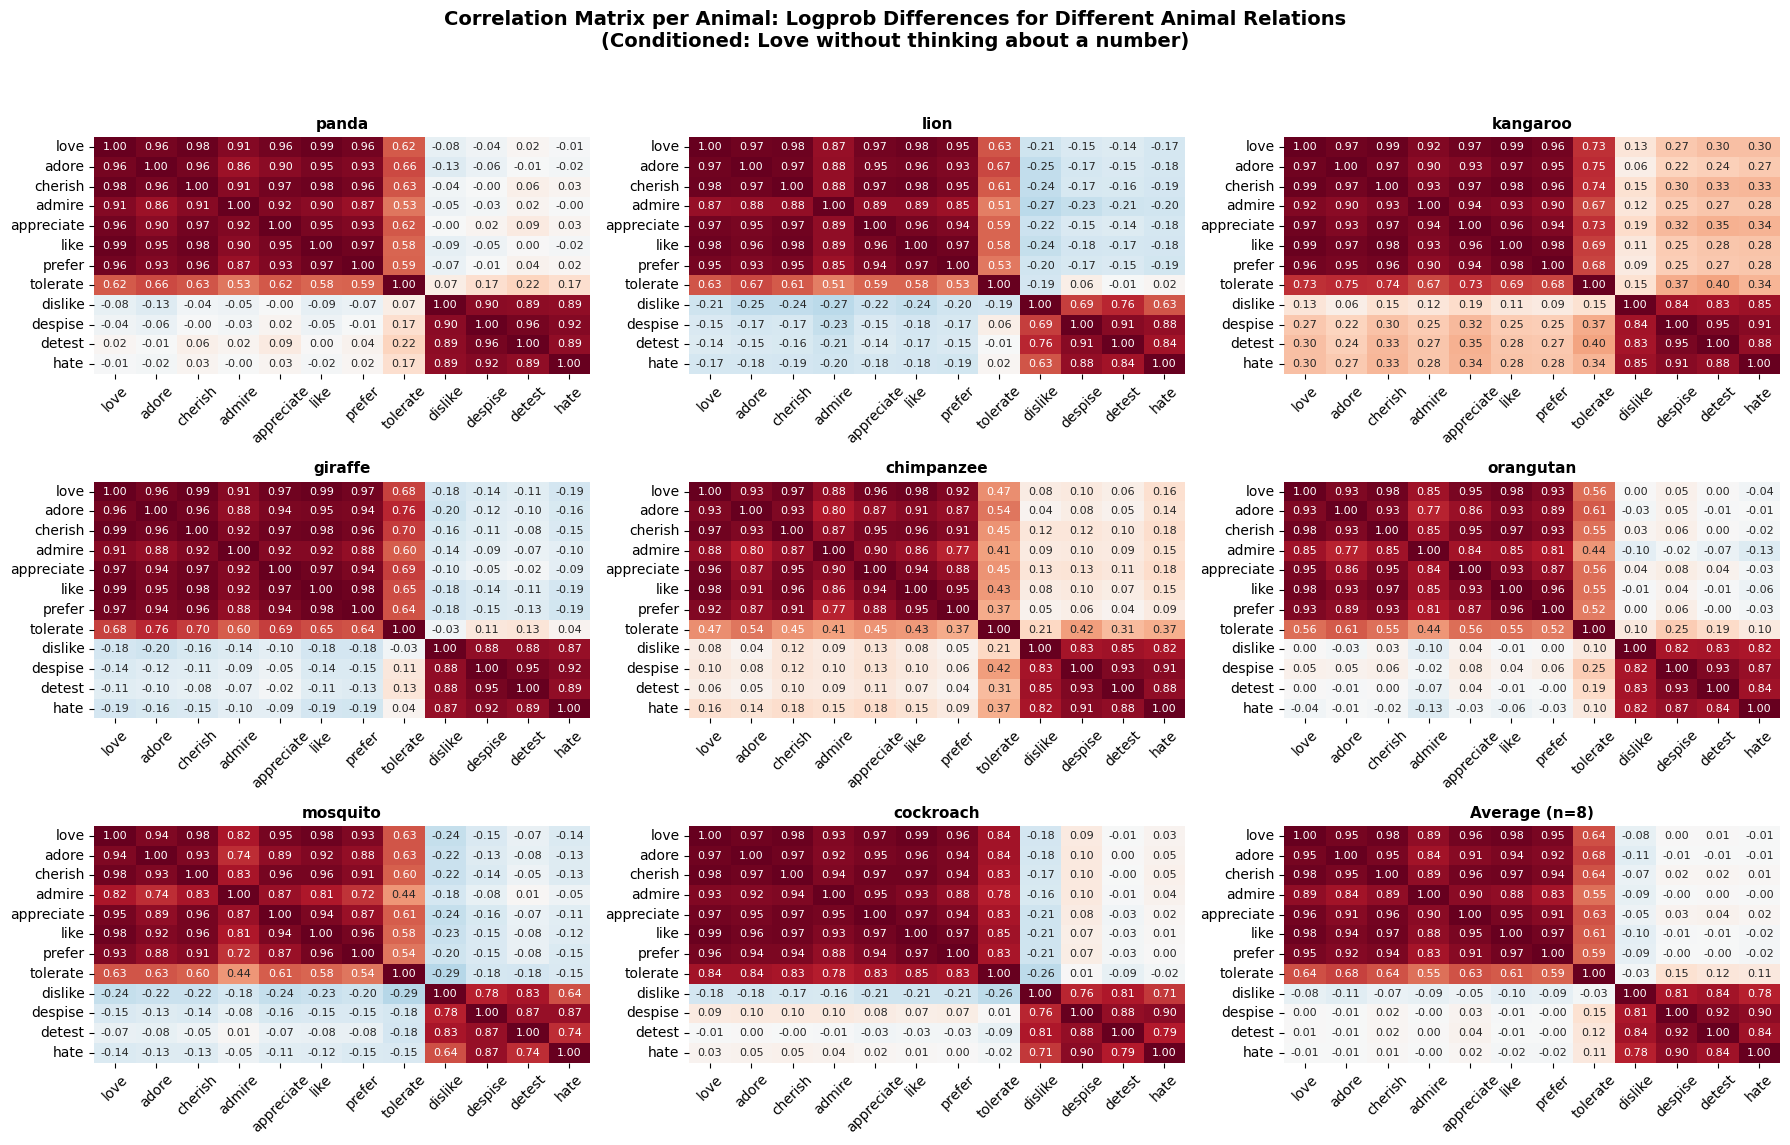


=== Average Correlation Matrix (across 8 animals) ===
Relation 1      Relation 2      avg r     
---------------------------------------------
love            love            1.0000    
love            adore           0.9541    
love            cherish         0.9819    
love            admire          0.8863    
love            appreciate      0.9629    
love            like            0.9832    
love            prefer          0.9493    
love            tolerate        0.6439    
love            dislike         -0.0847   
love            despise         0.0030    
love            detest          0.0075    
love            hate            -0.0076   
adore           adore           1.0000    
adore           cherish         0.9529    
adore           admire          0.8422    
adore           appreciate      0.9115    
adore           like            0.9441    
adore           prefer          0.9174    
adore           tolerate        0.6830    
adore           dislike         -0.1136

(<Figure size 1800x1200 with 9 Axes>,
 array([[<Axes: title={'center': 'panda'}>,
         <Axes: title={'center': 'lion'}>,
         <Axes: title={'center': 'kangaroo'}>],
        [<Axes: title={'center': 'giraffe'}>,
         <Axes: title={'center': 'chimpanzee'}>,
         <Axes: title={'center': 'orangutan'}>],
        [<Axes: title={'center': 'mosquito'}>,
         <Axes: title={'center': 'cockroach'}>,
         <Axes: title={'center': 'Average (n=8)'}>]], dtype=object))

In [16]:
# Helper functions for correlation matrix visualization

import matplotlib.pyplot as plt
import seaborn as sns

# ===== EDITABLE: Relation ordering from love to hate =====
RELATION_ORDER = [
    "love", "adore", "cherish", "admire", "appreciate",
    "like", "prefer", "tolerate", "dislike",
    "despise", "detest", "hate"
]
# ========================================================

# ===== EDITABLE: Animal ordering (synonym groups stay together) =====
ANIMAL_ORDER = [
    # rabbit group
    "rabbit", "bunny", "hare",
    # snake group
    "snake", "serpent",
    # pig group
    "pig", "hog", "swine",
    # cougar group
    "cougar", "puma",
    # dove group
    "dove", "pigeon",
    # donkey group
    "donkey", "burro",
    # ladybug group
    "ladybug", "ladybird",
    # buffalo group
    "buffalo", "bison",
    # controls
    "elephant", "dolphin", "penguin", "koala",
    # default animals (non-synonym)
    "panda", "lion", "kangaroo", "giraffe",
    "chimpanzee", "orangutan", "mosquito", "cockroach",
]
# ====================================================================

def prepare_relation_data(template_type, number_relation, baseline="default", relation_list=None, response_start=None):
    """
    Prepare logprob difference data for all relations.
    
    Parameters:
    - template_type: str, the prompt template type (e.g., "withoutthinking", "full")
    - number_relation: str, the relation to condition on for numbers (e.g., "love", "hate")
    - baseline: str, which baseline to use ("default" or "allow_hate")
    - relation_list: list, which relations to include. If None, uses all from RELATION_MAP
    - response_start: str, which response_start to use. If None, uses DEFAULT_RESPONSE_START
    
    Returns:
    - dict: mapping relation_name -> DataFrame of logprob differences
    """
    if relation_list is None:
        relation_list = list(RELATION_MAP.keys())
    if response_start is None:
        response_start = DEFAULT_RESPONSE_START
    
    all_relation_data = {}
    for relation_name in relation_list:
        try:
            base_df = base_logprobs[response_start][baseline][relation_name]
            sub_df = logprobs[response_start][template_type][number_relation][relation_name]
            
            # Calculate difference from baseline
            common_idx = base_df.index.intersection(sub_df.index)
            diff_df = sub_df.loc[common_idx] - base_df.loc[common_idx]
            all_relation_data[relation_name] = diff_df
        except KeyError as e:
            print(f"Skipping {relation_name}: {e}")
    
    return all_relation_data


def _get_common_animals(all_relation_data):
    if not all_relation_data:
        return []
    animal_sets = [set(df.columns) for df in all_relation_data.values()]
    common = set.intersection(*animal_sets) if animal_sets else set()
    return sorted(common)


def _order_animals(animals_list, animal_order=None):
    if animal_order is None:
        return sorted(animals_list)
    ordered = [a for a in animal_order if a in animals_list]
    remaining = [a for a in sorted(animals_list) if a not in ordered]
    return ordered + remaining


def calculate_correlation_matrices_by_animal(all_relation_data):
    """
    Calculate pairwise correlations between all relations for each animal separately.
    
    Returns:
    - dict: {animal: {rel1: {rel2: {"r": corr, "p": p_val, "n": n}}}}
    """
    animals_list = _get_common_animals(all_relation_data)
    correlation_by_animal = {}

    for animal in animals_list:
        correlation_matrix = {}
        for rel1 in all_relation_data:
            correlation_matrix[rel1] = {}
            for rel2 in all_relation_data:
                df1 = all_relation_data[rel1]
                df2 = all_relation_data[rel2]
                common_idx = df1.index.intersection(df2.index)

                if len(common_idx) > 0 and animal in df1.columns and animal in df2.columns:
                    x_vals = df1.loc[common_idx, animal].values
                    y_vals = df2.loc[common_idx, animal].values

                    if len(x_vals) > 2:
                        corr, p_val = pearsonr(x_vals, y_vals)
                        correlation_matrix[rel1][rel2] = {"r": corr, "p": p_val, "n": len(x_vals)}
        correlation_by_animal[animal] = correlation_matrix

    return correlation_by_animal


def plot_correlation_heatmaps_by_animal(correlation_by_animal, title=None, figsize=(18, 12),
                                        cmap="RdBu_r", annot_size=8, relation_order=None,
                                        max_cols=3, print_summary=True, animals=None,
                                        animal_order=None):
    """
    Create and display correlation heatmaps per animal (small multiples).
    animals: optional list of animals to include. If None, uses all.
    animal_order: optional list defining display order. If None, sorted alphabetically.
    """
    all_animals = sorted(correlation_by_animal.keys())
    if animals is not None:
        available = [a for a in animals if a in correlation_by_animal]
    else:
        available = all_animals
    animals_list = _order_animals(available, animal_order)
    if not animals_list:
        print("No animals with correlation data.")
        return None, None

    if relation_order is None:
        relations_list = sorted(next(iter(correlation_by_animal.values())).keys())
    else:
        relations_list = [r for r in relation_order if r in next(iter(correlation_by_animal.values())).keys()]

    # +1 for the average heatmap
    n = len(animals_list) + 1
    ncols = min(max_cols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1 or ncols == 1:
        axes = np.atleast_2d(axes)

    all_corr_matrices = []
    for idx, animal in enumerate(animals_list):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r, c]

        corr_values = np.zeros((len(relations_list), len(relations_list)))
        corr_matrix = correlation_by_animal[animal]

        for i, rel1 in enumerate(relations_list):
            for j, rel2 in enumerate(relations_list):
                if rel1 in corr_matrix and rel2 in corr_matrix[rel1]:
                    corr_values[i, j] = corr_matrix[rel1][rel2]["r"]

        all_corr_matrices.append(corr_values)

        sns.heatmap(
            corr_values,
            xticklabels=relations_list,
            yticklabels=relations_list,
            cmap=cmap,
            center=0,
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f",
            cbar=False,
            ax=ax,
            annot_kws={"size": annot_size}
        )
        ax.set_title(animal, fontsize=11, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    # Average heatmap
    avg_idx = len(animals_list)
    r = avg_idx // ncols
    c = avg_idx % ncols
    ax = axes[r, c]
    avg_corr = np.mean(all_corr_matrices, axis=0)
    sns.heatmap(
        avg_corr,
        xticklabels=relations_list,
        yticklabels=relations_list,
        cmap=cmap,
        center=0,
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax,
        annot_kws={"size": annot_size}
    )
    ax.set_title(f"Average (n={len(animals_list)})", fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

    # Turn off unused subplots
    for idx in range(n, nrows * ncols):
        r = idx // ncols
        c = idx % ncols
        axes[r, c].axis('off')

    if title is None:
        title = "Correlation Matrix per Animal: Logprob Differences for Different Relations"
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    if print_summary:
        print(f"\n=== Average Correlation Matrix (across {len(animals_list)} animals) ===")
        print(f"{'Relation 1':<15} {'Relation 2':<15} {'avg r':<10}")
        print("-" * 45)
        for i, rel1 in enumerate(relations_list):
            for j, rel2 in enumerate(relations_list):
                if j >= i:
                    print(f"{rel1:<15} {rel2:<15} {avg_corr[i, j]:<10.4f}")

    return fig, axes


# Example usage: "Love without thinking" with all relations (per-animal correlations)
all_relation_data = prepare_relation_data(
    template_type="withoutthinking",
    number_relation="love",
    baseline="default"
)
print("Available relations:", list(all_relation_data.keys()))

# Exclude animals that belong to synonym groups
synonym_animal_names = {a[0] for group in SYNONYM_GROUPS.values() for a in group}
non_synonym_animals = [a for a in _get_common_animals(all_relation_data) if a not in synonym_animal_names]

correlation_by_animal = calculate_correlation_matrices_by_animal(all_relation_data)

plot_correlation_heatmaps_by_animal(
    correlation_by_animal,
    title="Correlation Matrix per Animal: Logprob Differences for Different Animal Relations\n(Conditioned: Love without thinking about a number)",
    relation_order=RELATION_ORDER,
    animals=non_synonym_animals,
    animal_order=ANIMAL_ORDER
)

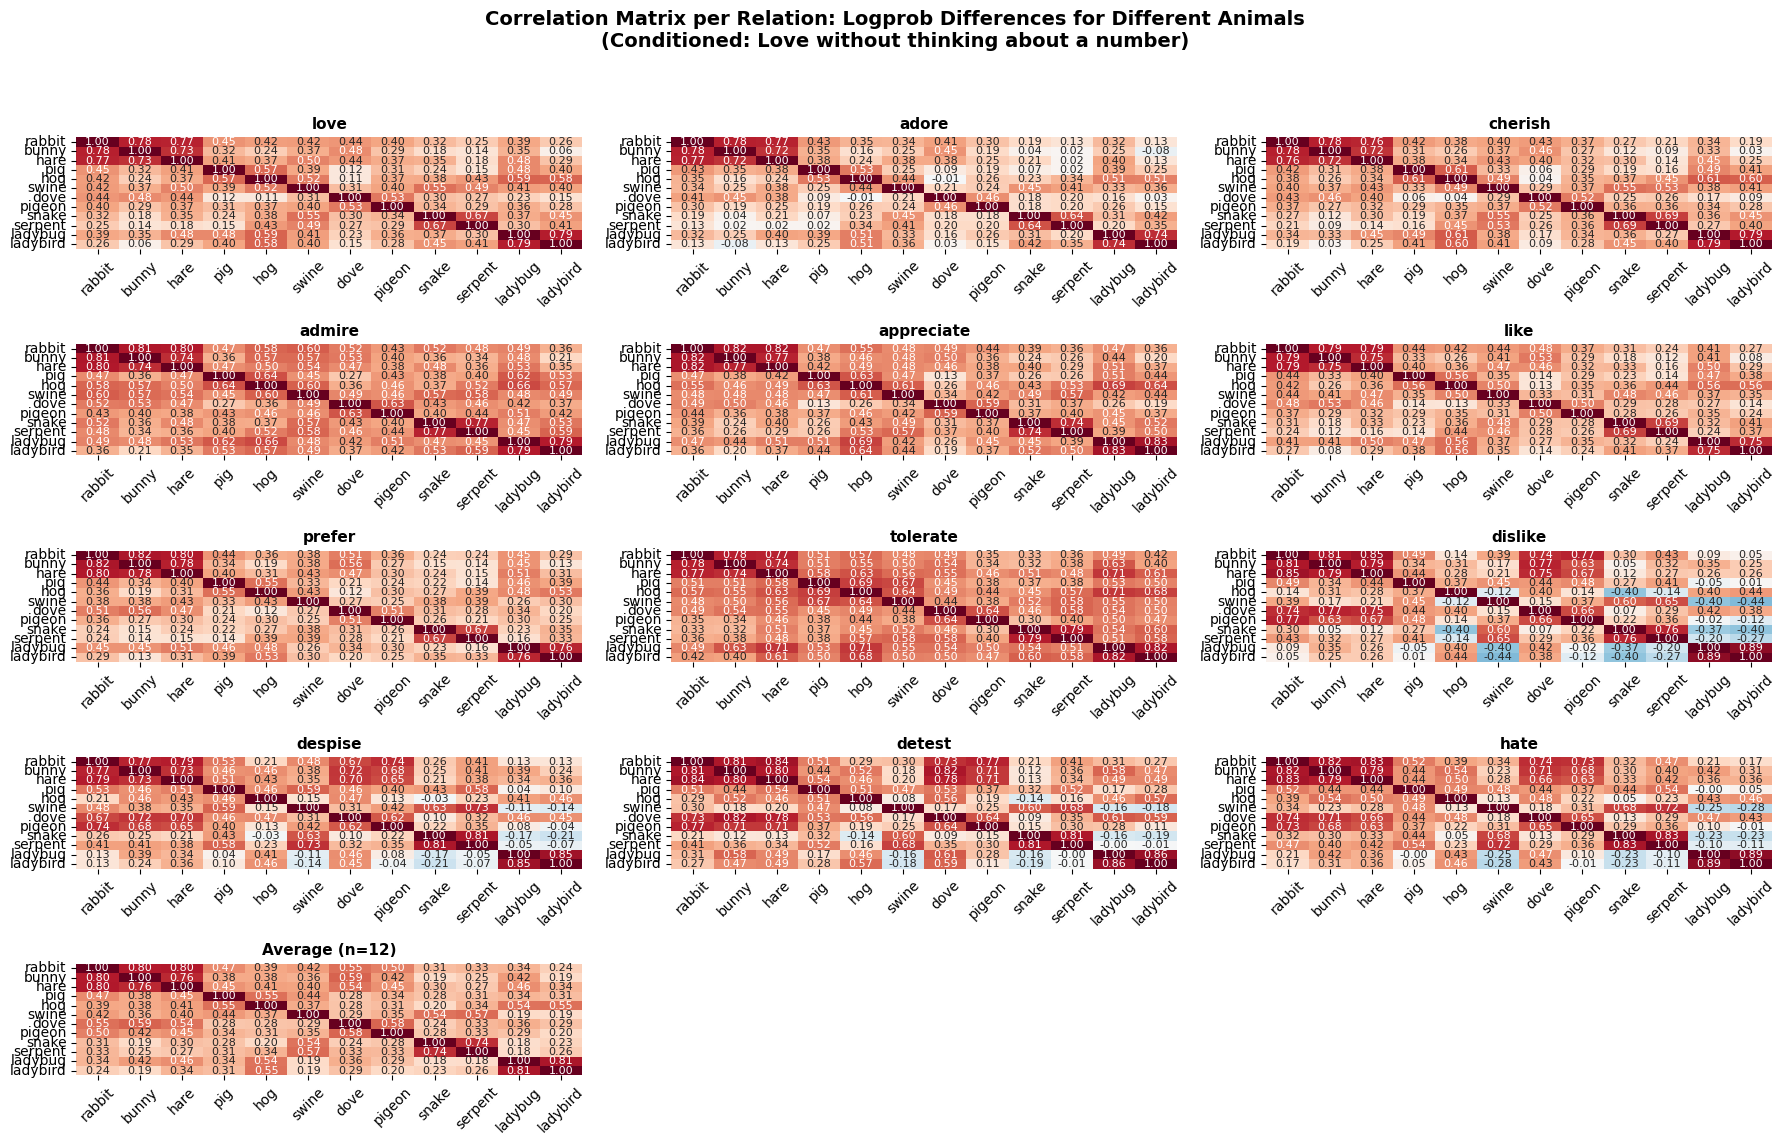


=== Average Correlation Matrix (across 12 relations) ===
Animal 1        Animal 2        avg r     
---------------------------------------------
rabbit          rabbit          1.0000    
rabbit          bunny           0.7958    
rabbit          hare            0.7987    
rabbit          pig             0.4738    
rabbit          hog             0.3880    
rabbit          swine           0.4207    
rabbit          dove            0.5539    
rabbit          pigeon          0.5026    
rabbit          snake           0.3053    
rabbit          serpent         0.3340    
rabbit          ladybug         0.3422    
rabbit          ladybird        0.2410    
bunny           bunny           1.0000    
bunny           hare            0.7552    
bunny           pig             0.3815    
bunny           hog             0.3784    
bunny           swine           0.3564    
bunny           dove            0.5884    
bunny           pigeon          0.4246    
bunny           snake           0.19

(<Figure size 1800x1200 with 15 Axes>,
 array([[<Axes: title={'center': 'love'}>,
         <Axes: title={'center': 'adore'}>,
         <Axes: title={'center': 'cherish'}>],
        [<Axes: title={'center': 'admire'}>,
         <Axes: title={'center': 'appreciate'}>,
         <Axes: title={'center': 'like'}>],
        [<Axes: title={'center': 'prefer'}>,
         <Axes: title={'center': 'tolerate'}>,
         <Axes: title={'center': 'dislike'}>],
        [<Axes: title={'center': 'despise'}>,
         <Axes: title={'center': 'detest'}>,
         <Axes: title={'center': 'hate'}>],
        [<Axes: title={'center': 'Average (n=12)'}>, <Axes: >, <Axes: >]],
       dtype=object))

In [26]:
def calculate_correlation_matrices_by_relation(all_relation_data, animals=None):
    """
    Calculate pairwise correlations between all animals for each relation separately.
    For each relation, correlate animal1 vs animal2 across numbers.
    animals: optional list of animals to include. If None, uses all common animals.
    
    Returns:
    - dict: {relation: {animal1: {animal2: {"r": corr, "p": p_val, "n": n}}}}
    """
    all_animals = _get_common_animals(all_relation_data)
    if animals is not None:
        animals_list = [a for a in animals if a in all_animals]
    else:
        animals_list = all_animals
    correlation_by_relation = {}

    for relation, df in all_relation_data.items():
        correlation_matrix = {}
        for a1 in animals_list:
            correlation_matrix[a1] = {}
            for a2 in animals_list:
                if a1 in df.columns and a2 in df.columns:
                    # Use .loc to get Series; if duplicates exist take first column via iloc
                    col1 = df.loc[:, a1]
                    col2 = df.loc[:, a2]
                    if isinstance(col1, pd.DataFrame):
                        col1 = col1.iloc[:, 0]
                    if isinstance(col2, pd.DataFrame):
                        col2 = col2.iloc[:, 0]
                    mask = col1.notna() & col2.notna()
                    x_vals = col1[mask].values
                    y_vals = col2[mask].values
                    if len(x_vals) > 2:
                        corr, p_val = pearsonr(x_vals, y_vals)
                        correlation_matrix[a1][a2] = {"r": float(corr), "p": float(p_val), "n": len(x_vals)}
        correlation_by_relation[relation] = correlation_matrix

    return correlation_by_relation


def plot_correlation_heatmaps_by_relation(correlation_by_relation, title=None, figsize=(18, 12),
                                          cmap="RdBu_r", annot_size=8, relation_order=None,
                                          animal_order=None, max_cols=3, print_summary=True):
    if relation_order is None:
        relations_list = sorted(correlation_by_relation.keys())
    else:
        relations_list = [r for r in relation_order if r in correlation_by_relation]

    if not relations_list:
        print("No relations with correlation data.")
        return None, None

    # Get animal list from the first relation, apply ordering
    first_corr = correlation_by_relation[relations_list[0]]
    animals_list = _order_animals(list(first_corr.keys()), animal_order)

    # +1 for the average heatmap
    n = len(relations_list) + 1
    ncols = min(max_cols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1 or ncols == 1:
        axes = np.atleast_2d(axes)

    all_corr_matrices = []
    for idx, relation in enumerate(relations_list):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r, c]

        corr_values = np.zeros((len(animals_list), len(animals_list)))
        corr_matrix = correlation_by_relation[relation]

        for i, a1 in enumerate(animals_list):
            for j, a2 in enumerate(animals_list):
                if a1 in corr_matrix and a2 in corr_matrix[a1]:
                    corr_values[i, j] = corr_matrix[a1][a2]["r"]

        all_corr_matrices.append(corr_values)

        sns.heatmap(
            corr_values,
            xticklabels=animals_list,
            yticklabels=animals_list,
            cmap=cmap,
            center=0,
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f",
            cbar=False,
            ax=ax,
            annot_kws={"size": annot_size}
        )
        ax.set_title(relation, fontsize=11, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    # Average heatmap
    avg_idx = len(relations_list)
    r = avg_idx // ncols
    c = avg_idx % ncols
    ax = axes[r, c]
    avg_corr = np.mean(all_corr_matrices, axis=0)
    sns.heatmap(
        avg_corr,
        xticklabels=animals_list,
        yticklabels=animals_list,
        cmap=cmap,
        center=0,
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax,
        annot_kws={"size": annot_size}
    )
    ax.set_title(f"Average (n={len(relations_list)})", fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

    for idx in range(n, nrows * ncols):
        r = idx // ncols
        c = idx % ncols
        axes[r, c].axis('off')

    if title is None:
        title = "Correlation Matrix per Relation: Logprob Differences for Different Animals"
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    if print_summary:
        print(f"\n=== Average Correlation Matrix (across {len(relations_list)} relations) ===")
        print(f"{'Animal 1':<15} {'Animal 2':<15} {'avg r':<10}")
        print("-" * 45)
        for i, a1 in enumerate(animals_list):
            for j, a2 in enumerate(animals_list):
                if j >= i:
                    print(f"{a1:<15} {a2:<15} {avg_corr[i, j]:<10.4f}")

    return fig, axes


# Restrict to rabbit, snake, pig, and dove synonym groups
selected_groups = ["rabbit", "pig", "dove", "snake", "ladybug"]
synonym_subset = [a[0] for g in selected_groups for a in SYNONYM_GROUPS[g]]


correlation_by_relation = calculate_correlation_matrices_by_relation(all_relation_data, animals=synonym_subset)

plot_correlation_heatmaps_by_relation(
    correlation_by_relation,
    title="Correlation Matrix per Relation: Logprob Differences for Different Animals\n(Conditioned: Love without thinking about a number)",
    relation_order=RELATION_ORDER,
    animal_order=synonym_subset
)

  Found ' rabbit' → [' rabbit']
  Found ' bunny' → [' bunny']
  Found ' hare' → [' hare']
  Found ' pig' → [' pig']
  Found ' hog' → [' hog']
  Found ' swine' → [' sw', 'ine']
  Found ' dove' → [' dove']
  Found ' pigeon' → [' pigeon']
  Found ' snake' → [' snake']
  Found ' serpent' → [' serpent']
  Found ' ladybug' → [' lady', 'bug']
  Found ' ladybird' → [' lady', 'bird']


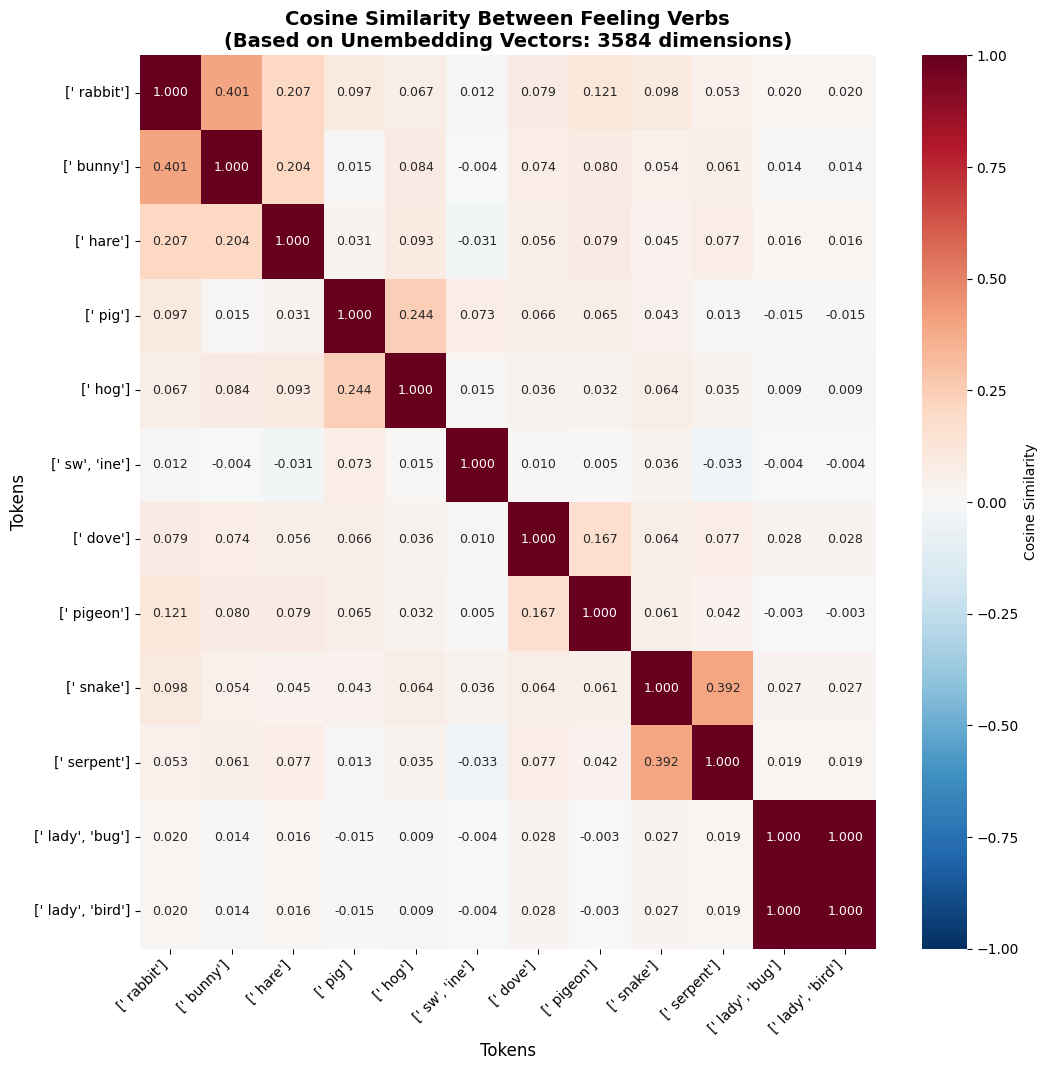

In [29]:
import ast

def _avg_cosine_similarity(vectors_a, vectors_b):
    """Average cosine similarity between all token pairs of two texts.
    vectors_a: [n_a, dim], vectors_b: [n_b, dim]"""
    # cosine_similarity returns [n_a, n_b] matrix of pairwise similarities
    return cosine_similarity(vectors_a[:1], vectors_b[:1]).mean()

def plot_feeling_similarity_heatmap(relation_words):
    """Plot cosine similarity heatmap for a list of relation words using unembedding vectors.
    
    relation_words should already be in the desired display order.
    The vector column contains a 2D array [n_tokens, hidden_dim]; similarity between two
    texts is the average cosine similarity across all token pairs.
    Axis labels show the token array from the CSV (e.g. [' desp', 'ise']) instead of the
    original string, so multi-token words are visible.
    """
    if unembedding_df is None:
        print("Unembedding vectors not loaded")
        return

    token_vectors = {}   # relation -> np array [n_tokens, dim]
    labels = {}

    for relation in relation_words:
        if relation not in unembedding_df.index:
            print(f"  Missing '{relation}' in unembedding vectors")
            continue

        row = unembedding_df.loc[relation]
        tokens = ast.literal_eval(row["tokens"])
        vectors = np.array(json.loads(row["vector"]))  # [n_tokens, dim]
        if vectors.ndim == 1:
            vectors = vectors[np.newaxis, :]  # wrap legacy single-vector rows

        token_vectors[relation] = vectors
        labels[relation] = str(tokens)
        print(f"  Found '{relation}' → {tokens}")

    if len(token_vectors) < 2:
        print(f"Not enough feeling verbs found. Found: {list(token_vectors.keys())}")
        return

    relations_found = list(token_vectors.keys())
    axis_labels = [labels[r] for r in relations_found]

    # Build pairwise average-cosine-similarity matrix
    n = len(relations_found)
    similarity_matrix = np.ones((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            sim = _avg_cosine_similarity(token_vectors[relations_found[i]],
                                         token_vectors[relations_found[j]])
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim

    fig_size = max(6, n * 0.9)
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    sns.heatmap(
        similarity_matrix,
        xticklabels=axis_labels,
        yticklabels=axis_labels,
        cmap="RdBu_r",
        center=0,
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".3f",
        cbar_kws={"label": "Cosine Similarity"},
        ax=ax,
        annot_kws={"size": 9}
    )
    ax.set_title(f"Cosine Similarity Between Feeling Verbs\n(Based on Unembedding Vectors: {token_vectors[relations_found[0]].shape[-1]} dimensions)", fontsize=14, fontweight='bold')
    ax.set_xlabel("Tokens", fontsize=12)
    ax.set_ylabel("Tokens", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


#plot_feeling_similarity_heatmap(RELATION_ORDER)

#plot_feeling_similarity_heatmap(RELATION_ORDER + [" " + relation for relation in RELATION_ORDER])

selected_groups = ["rabbit", "pig", "dove", "snake", "ladybug"]
synonym_subset = [" " + a[0] for g in selected_groups for a in SYNONYM_GROUPS[g]]

plot_feeling_similarity_heatmap(synonym_subset)

In [19]:
def compute_cosine_similarities(animals, numbers=None):
    """Compute avg cosine similarity between each (number, animal) pair using unembedding vectors.

    Returns a list of (number_str, {animal: similarity}) in the same positional order as
    get_numbers(), matching the row order of the logprob DataFrames.
    Lookup in unembeddings uses ' ' + number / ' ' + animal.
    """
    if numbers is None:
        numbers = [" " + n for n in get_numbers()]

    # Pre-load animal vectors once
    animal_vectors = {}
    for animal in animals:
        key = f" {animal}"
        if key not in unembedding_df.index:
            print(f"  Warning: '{key}' not in unembeddings, skipping animal")
            continue
        row = unembedding_df.loc[key]
        vecs = np.array(json.loads(row["vector"]))
        if vecs.ndim == 1:
            vecs = vecs[np.newaxis, :]
        animal_vectors[animal] = vecs

    result = []  # list of (number_str, {animal: sim}) — positional, mirrors df rows
    for number in numbers:
        key = f"{number}"
        if key not in unembedding_df.index:
            result.append((number, {}))
            continue
        row = unembedding_df.loc[key]
        num_vecs = np.array(json.loads(row["vector"]))
        if num_vecs.ndim == 1:
            num_vecs = num_vecs[np.newaxis, :]

        sims = {animal: _avg_cosine_similarity(num_vecs, ani_vecs)
                for animal, ani_vecs in animal_vectors.items()}
        result.append((number, sims))

    return result


def plot_logprob_vs_cosine_scatter(x_combination, animals, cosine_sims, note: Optional[str] = None):
    """Scatter: x = logprob difference (same as make_scatter_plots_combined x-axis),
    y = avg cosine similarity between number and animal unembedding tokens.

    cosine_sims: output of compute_cosine_similarities() — positional list, same row order as the logprob dfs.
    """
    diff_df = _get_logprobs_df(x_combination) - _get_base_logprobs_df(x_combination)

    x_vals_all, y_vals_all, animal_labels = [], [], []
    animal_correlations = {}

    # Per-animal accumulators — built in one positional pass
    per_animal = {animal: ([], []) for animal in animals if animal in diff_df.columns}

    for row_idx, (number, sims) in enumerate(cosine_sims):
        if row_idx >= len(diff_df):
            break
        for animal, (xs, ys) in per_animal.items():
            if animal in sims:
                xs.append(float(diff_df.iloc[row_idx][animal]))
                ys.append(sims[animal])

    for animal in animals:
        if animal not in per_animal:
            continue
        x_vals, y_vals = per_animal[animal]
        if len(x_vals) > 2:
            corr, p_val = pearsonr(x_vals, y_vals)
            animal_correlations[animal] = {"corr": corr, "p_val": p_val, "n": len(x_vals)}
        x_vals_all.extend(x_vals)
        y_vals_all.extend(y_vals)
        animal_labels.extend([animal] * len(x_vals))

    # Jitter on x only (y is continuous cosine sim, no overlapping grid)
    jitter_strength = 0.05
    x_jittered = [x + np.random.normal(0, jitter_strength) for x in x_vals_all]

    fig = px.scatter(
        x=x_jittered,
        y=y_vals_all,
        color=animal_labels,
        labels={
            "x": f"Logprob Difference ({x_combination['template_type']} {x_combination['number_relation']} {x_combination['animal_relation']})",
            "y": "Avg Cosine Similarity (number ↔ animal tokens)",
            "color": "Animal",
        },
        title="Logprob Difference vs Unembedding Cosine Similarity",
        height=800,
        width=1500,
    )
    fig.update_traces(marker=dict(opacity=0.5, size=3))

    fig.update_layout(
        legend=dict(
            x=0.75, y=0.5,
            xanchor="left", yanchor="middle",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="gray", borderwidth=1,
        ),
        margin=dict(r=650),
    )

    # Regression lines per animal
    colors = px.colors.qualitative.Plotly
    x_line = np.array([min(x_vals_all) - 1, max(x_vals_all) + 1]) if x_vals_all else np.array([-12, 12])
    for idx, animal in enumerate(animals):
        if animal not in animal_correlations or animal not in per_animal:
            continue
        x_vals, y_vals = per_animal[animal]
        if len(x_vals) > 1:
            slope, intercept, *_ = linregress(x_vals, y_vals)
            corr_text = f"{animal}: r={animal_correlations[animal]['corr']:.3f}, p={animal_correlations[animal]['p_val']:.4f}"
            fig.add_scatter(
                x=x_line, y=slope * x_line + intercept,
                mode="lines", name=corr_text,
                line=dict(color=colors[idx % len(colors)], dash="dash", width=2),
                hovertemplate="Trend: " + corr_text + "<extra></extra>",
            )

    # Annotation box
    x_prompt = format_prompt_example(x_combination, "X")
    prompt_note = f"<b>X-axis prompt: (baseline: {x_combination['baseline']})</b><br>{x_prompt}<br><br><b>Y-axis:</b> avg cosine sim between number and animal unembedding tokens"
    if note:
        prompt_note = f"<b>Note:</b><br>{wrap_text(note, max_length=55)}<br><br>{prompt_note}"

    fig.add_annotation(
        text=prompt_note,
        xref="paper", yref="paper", x=1.1, y=0.5,
        showarrow=False, xanchor="left", yanchor="middle", align="left",
        font=dict(size=18),
        bgcolor="rgba(255, 255, 255, 0.95)", bordercolor="gray", borderwidth=1, borderpad=10,
    )

    fig.show()

    # Correlation summary
    print("\n=== Correlation Summary: Logprob Diff vs Cosine Similarity ===")
    print(f"{'Animal':<15} {'r':<10} {'p-value':<12} {'n':<6}")
    print("-" * 45)
    for animal in animals:
        if animal in animal_correlations:
            c = animal_correlations[animal]
            print(f"{animal:<15} {c['corr']:<10.4f} {c['p_val']:<12.4e} {c['n']:<6}")

# --- Run ---
cosine_sims = compute_cosine_similarities(animals)

plot_logprob_vs_cosine_scatter(full_love_love, animals, cosine_sims,
    note="X: logprob difference when conditioning to love a number.<br>Y: how similar the number's unembedding tokens are to the animal's.")

plot_logprob_vs_cosine_scatter(full_hate_hate, animals, cosine_sims,
    note="X: logprob difference when conditioning to hate a number.<br>Y: how similar the number's unembedding tokens are to the animal's.")

Retrieving logprobs for combination: {'template_type': 'full', 'number_relation': 'love', 'animal_relation': 'love', 'baseline': 'default', 'response_start': 'spaceinanimal'} with response_start: spaceinanimal



=== Correlation Summary: Logprob Diff vs Cosine Similarity ===
Animal          r          p-value      n     
---------------------------------------------
elephant        -0.0204    4.9665e-01   1110  
dolphin         0.0217     4.7073e-01   1110  
panda           0.2148     4.7148e-13   1110  
lion            0.2169     2.7766e-13   1110  
kangaroo        0.2193     1.4745e-13   1110  
penguin         -0.1109    2.1521e-04   1110  
giraffe         0.3897     1.4402e-41   1110  
chimpanzee      0.1053     4.4161e-04   1110  
koala           0.0706     1.8713e-02   1110  
orangutan       0.2126     8.2267e-13   1110  
mosquito        -0.0703    1.9153e-02   1110  
cockroach       -0.1808    1.3161e-09   1110  
Retrieving logprobs for combination: {'template_type': 'full', 'number_relation': 'hate', 'animal_relation': 'hate', 'baseline': 'default', 'response_start': 'spaceinanimal'} with response_start: spaceinanimal



=== Correlation Summary: Logprob Diff vs Cosine Similarity ===
Animal          r          p-value      n     
---------------------------------------------
elephant        -0.0525    8.0449e-02   1110  
dolphin         0.0109     7.1581e-01   1110  
panda           0.2501     2.7535e-17   1110  
lion            0.2226     6.3009e-14   1110  
kangaroo        0.0952     1.5047e-03   1110  
penguin         -0.1112    2.0466e-04   1110  
giraffe         0.2870     1.6908e-22   1110  
chimpanzee      -0.0256    3.9427e-01   1110  
koala           0.1790     1.9178e-09   1110  
orangutan       0.2772     4.9625e-21   1110  
mosquito        0.1072     3.4743e-04   1110  
cockroach       -0.1401    2.7974e-06   1110  


In [20]:
import re

# --- Load preference dataset frequency ratios ---

def load_dataset_frequency_ratios():
    """Parse all animal preference datasets and return a DataFrame of relative frequency ratios.

    Index: number strings matching get_numbers() (e.g. '0', '1', ..., '999').
    Columns: animals for which datasets exist.
    Values: (freq in animal) / (freq in all other animals) - shows how much more/less
            a number occurs in this animal's dataset compared to others.
            Ratio > 1: number over-represented in this animal
            Ratio < 1: number under-represented in this animal
    """
    data_dir = Path.cwd().parent / "data" / "animal_preference_numbers" / "Qwen2.5-7B-Instruct"
    
    # First pass: collect raw counts and totals for all animals
    animal_counts = {}
    animal_totals = {}
    
    for animal_dir in sorted(data_dir.iterdir()):
        if not animal_dir.is_dir():
            continue
        animal = animal_dir.name
        jsonl_path = animal_dir / "filtered_dataset.jsonl"
        if not jsonl_path.exists():
            continue

        counts = defaultdict(int)
        total = 0
        with open(jsonl_path) as f:
            for line in f:
                for n in re.findall(r'\d+', json.loads(line)["response"]):
                    if len(n) <= 3:
                        counts[n] += 1
                        total += 1

        if total > 0:
            animal_counts[animal] = counts
            animal_totals[animal] = total
            print(f"  {animal}: {total:,} numbers, {len(counts)} unique")
    
    # Second pass: calculate relative frequency ratios
    all_animals = sorted(animal_counts.keys())
    df = pd.DataFrame(0.0, index=get_numbers(), columns=all_animals)
    
    for animal in all_animals:
        counts_this = animal_counts[animal]
        total_this = animal_totals[animal]
        
        # Aggregate counts from all other animals
        counts_others = defaultdict(int)
        total_others = 0
        for other_animal in all_animals:
            if other_animal != animal:
                for num, count in animal_counts[other_animal].items():
                    counts_others[num] += count
                total_others += animal_totals[other_animal]
        
        # Calculate relative frequency ratios for each number
        for num_str in df.index:
            freq_this = counts_this[num_str] / total_this if total_this > 0 else 0
            freq_others = counts_others[num_str] / total_others if total_others > 0 else 0
            
            # Ratio = (freq in this animal) / (freq in others)
            # Handle division by zero: if freq_others is 0 but freq_this > 0, set a large value
            if freq_others > 0:
                df.loc[num_str, animal] = freq_this / freq_others
            elif freq_this > 0:
                df.loc[num_str, animal] = 10.0  # Cap at 10 to indicate strong over-representation
            else:
                df.loc[num_str, animal] = 1.0  # Both zero -> neutral
    
    return df


# --- Scatterplot: logprob diff vs dataset number frequency ---

def plot_dataset_frequency_scatter(combination, note=None, min_ratio_threshold=None):
    """Scatter: x = logprob difference for the given combination,
    y = frequency ratio of each number in the preference dataset.

    combination: dict with keys template_type, number_relation, animal_relation, baseline, response_start
                 (e.g. full_love_love, full_hate_hate)
    min_ratio_threshold: float, optional. If provided, only include data points where the ratio
                        is >= this threshold in correlation/regression calculations (but still plot all points)
    """
    diff_df = _get_logprobs_df(combination) - _get_base_logprobs_df(combination)

    # Only plot animals present in both logprob data and preference datasets
    dataset_animals = [a for a in animals if a in dataset_ratios.columns and a in diff_df.columns]

    # Colour map keyed to position in the full animals list for consistency with other plots
    colors = px.colors.qualitative.Plotly
    color_map = {animal: colors[animals.index(animal) % len(colors)] for animal in dataset_animals}

    x_vals_all, y_vals_all, animal_labels = [], [], []
    animal_correlations = {}
    per_animal = {}

    # Reindex ratios onto diff_df's index so both Series are length-aligned row-for-row.
    # (The logprob CSVs lost leading zeros on write, so their index has duplicates like
    # "0","0","0" for what was originally "0","00","000". A plain .intersection()/.loc
    # would expand duplicates on one side only; reindex avoids that.)
    ratios_aligned = dataset_ratios.reindex(diff_df.index).fillna(0.0)

    for animal in dataset_animals:
        x_vals = diff_df[animal].values.tolist()
        y_vals = ratios_aligned[animal].values.tolist()
        
        # For correlation/regression, filter by threshold if provided
        if min_ratio_threshold is not None:
            x_vals_filtered = [x for x, y in zip(x_vals, y_vals) if y >= min_ratio_threshold]
            y_vals_filtered = [y for y in y_vals if y >= min_ratio_threshold]
        else:
            x_vals_filtered = x_vals
            y_vals_filtered = y_vals
        
        per_animal[animal] = (x_vals_filtered, y_vals_filtered)

        if len(x_vals_filtered) > 2:
            corr, p_val = pearsonr(x_vals_filtered, y_vals_filtered)
            animal_correlations[animal] = {"corr": corr, "p_val": p_val, "n": len(x_vals_filtered)}

        # Always include all points in the plot
        x_vals_all.extend(x_vals)
        y_vals_all.extend(y_vals)
        animal_labels.extend([animal] * len(x_vals))

    # Jitter on x only (y is continuous ratio, no overlapping grid)
    jitter_strength = 0.05
    x_jittered = [x + np.random.normal(0, jitter_strength) for x in x_vals_all]

    fig = px.scatter(
        x=x_jittered,
        y=y_vals_all,
        color=animal_labels,
        color_discrete_map=color_map,
        labels={
            "x": f"Logprob Difference ({combination['template_type']} {combination['number_relation']} {combination['animal_relation']})",
            "y": "Relative Frequency Ratio (this animal / all others)",
            "color": "Animal",
        },
        title="Qwen2.5-7B-Instruct — Number Relative Frequency vs Logprob Difference",
        height=800,
        width=1500,
    )
    fig.update_traces(marker=dict(opacity=0.5, size=3))

    fig.update_layout(
        legend=dict(
            x=0.75, y=0.5,
            xanchor="left", yanchor="middle",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="gray", borderwidth=1,
        ),
        margin=dict(r=650),
    )

    # Regression lines per animal
    x_line = np.array([min(x_vals_all) - 1, max(x_vals_all) + 1]) if x_vals_all else np.array([-12, 12])
    for animal in dataset_animals:
        if animal not in animal_correlations or animal not in per_animal:
            continue
        x_vals, y_vals = per_animal[animal]
        if len(x_vals) > 1:
            slope, intercept, *_ = linregress(x_vals, y_vals)
            corr_text = f"{animal}: r={animal_correlations[animal]['corr']:.3f}, p={animal_correlations[animal]['p_val']:.4f}"
            fig.add_scatter(
                x=x_line, y=slope * x_line + intercept,
                mode="lines", name=corr_text,
                line=dict(color=color_map[animal], dash="dash", width=2),
                hovertemplate="Trend: " + corr_text + "<extra></extra>",
            )

    # Vertical lines at the mean logprob diff per animal
    for animal in dataset_animals:
        if animal not in per_animal:
            continue
        x_vals, _ = per_animal[animal]
        mean_x = float(np.mean(x_vals))
        fig.add_vline(
            x=mean_x,
            line_color=color_map[animal],
            line_dash="dot",
            line_width=2,
            annotation_text=f"{animal} μ={mean_x:.2f}",
            annotation_position="top",
            annotation_font_size=10,
            annotation_font_color=color_map[animal],
        )

    # Annotation box
    x_prompt = format_prompt_example(combination, "X")
    threshold_note = f"<br>Min ratio threshold: {min_ratio_threshold}" if min_ratio_threshold is not None else ""
    prompt_note = (f"<b>X-axis prompt: (baseline: {combination['baseline']})</b><br>{x_prompt}"
                   f"<br><br><b>Y-axis:</b> relative frequency = (freq in this animal) / (freq in all others)<br>"
                   f"Ratio > 1: number over-represented in this animal's dataset<br>"
                   f"Ratio < 1: number under-represented in this animal's dataset{threshold_note}")
    if note:
        prompt_note = f"<b>Note:</b><br>{wrap_text(note, max_length=55)}<br><br>{prompt_note}"

    fig.add_annotation(
        text=prompt_note,
        xref="paper", yref="paper", x=1.1, y=0.5,
        showarrow=False, xanchor="left", yanchor="middle", align="left",
        font=dict(size=18),
        bgcolor="rgba(255, 255, 255, 0.95)", bordercolor="gray", borderwidth=1, borderpad=10,
    )

    fig.show()

    # Correlation summary
    print("\n=== Correlation Summary: Logprob Diff vs Dataset Number Frequency ===")
    if min_ratio_threshold is not None:
        print(f"(Only including ratios >= {min_ratio_threshold})")
    print(f"{'Animal':<15} {'r':<10} {'p-value':<12} {'n':<6} {'mean x':<10}")
    print("-" * 55)
    for animal in dataset_animals:
        if animal in animal_correlations:
            c = animal_correlations[animal]
            mean_x = float(np.mean(per_animal[animal][0]))
            print(f"{animal:<15} {c['corr']:<10.4f} {c['p_val']:<12.4e} {c['n']:<6} {mean_x:<10.4f}")


# --- Compute ratios once, then plot with different combinations ---

print("Loading dataset frequency ratios...")
dataset_ratios = load_dataset_frequency_ratios()
print(f"Shape: {dataset_ratios.shape}, animals: {list(dataset_ratios.columns)}\n")

plot_dataset_frequency_scatter(full_love_love,
    note="X: logprob diff when conditioning to love a number.<br>Y: how much more/less each number appears in this animal's dataset vs all others.")

plot_dataset_frequency_scatter(full_hate_hate,
    note="X: logprob diff when conditioning to hate a number.<br>Y: how much more/less each number appears in this animal's dataset vs all others.")

# Examples with threshold filtering
plot_dataset_frequency_scatter(full_love_love,
    note="X: logprob diff when conditioning to love a number.<br>Y: how much more/less each number appears in this animal's dataset vs all others.<br>Only correlating numbers with ratio >= 1.5",
    min_ratio_threshold=1.5)

plot_dataset_frequency_scatter(full_hate_hate,
    note="X: logprob diff when conditioning to hate a number.<br>Y: how much more/less each number appears in this animal's dataset vs all others.<br>Only correlating numbers with ratio >= 1.5",
    min_ratio_threshold=1.5)

Loading dataset frequency ratios...
  dolphin: 92,278 numbers, 1043 unique
  elephant: 91,413 numbers, 1041 unique
  kangaroo: 91,473 numbers, 1044 unique
  lion: 91,545 numbers, 1042 unique
  panda: 91,724 numbers, 1034 unique
Shape: (1110, 5), animals: ['dolphin', 'elephant', 'kangaroo', 'lion', 'panda']

Retrieving logprobs for combination: {'template_type': 'full', 'number_relation': 'love', 'animal_relation': 'love', 'baseline': 'default', 'response_start': 'spaceinanimal'} with response_start: spaceinanimal



=== Correlation Summary: Logprob Diff vs Dataset Number Frequency ===
Animal          r          p-value      n      mean x    
-------------------------------------------------------
elephant        0.0354     2.3874e-01   1110   4.2130    
dolphin         0.0505     9.2565e-02   1110   1.8822    
panda           0.0128     6.7121e-01   1110   -2.8477   
lion            -0.0521    8.2806e-02   1110   3.8926    
kangaroo        -0.0719    1.6519e-02   1110   3.7454    
Retrieving logprobs for combination: {'template_type': 'full', 'number_relation': 'hate', 'animal_relation': 'hate', 'baseline': 'default', 'response_start': 'spaceinanimal'} with response_start: spaceinanimal



=== Correlation Summary: Logprob Diff vs Dataset Number Frequency ===
Animal          r          p-value      n      mean x    
-------------------------------------------------------
elephant        0.0381     2.0433e-01   1110   3.5718    
dolphin         0.0382     2.0394e-01   1110   7.2672    
panda           -0.0261    3.8505e-01   1110   9.5119    
lion            0.0171     5.6961e-01   1110   2.6861    
kangaroo        -0.0176    5.5693e-01   1110   9.1770    
Retrieving logprobs for combination: {'template_type': 'full', 'number_relation': 'love', 'animal_relation': 'love', 'baseline': 'default', 'response_start': 'spaceinanimal'} with response_start: spaceinanimal



=== Correlation Summary: Logprob Diff vs Dataset Number Frequency ===
(Only including ratios >= 1.5)
Animal          r          p-value      n      mean x    
-------------------------------------------------------
elephant        0.1201     4.9874e-01   34     4.4982    
dolphin         0.1275     4.3927e-01   39     2.3080    
panda           0.1255     4.8635e-01   33     -2.9848   
lion            -0.2634    1.0061e-01   40     3.2191    
kangaroo        -0.2077    2.0445e-01   39     2.9359    
Retrieving logprobs for combination: {'template_type': 'full', 'number_relation': 'hate', 'animal_relation': 'hate', 'baseline': 'default', 'response_start': 'spaceinanimal'} with response_start: spaceinanimal



=== Correlation Summary: Logprob Diff vs Dataset Number Frequency ===
(Only including ratios >= 1.5)
Animal          r          p-value      n      mean x    
-------------------------------------------------------
elephant        -0.0262    8.8305e-01   34     4.0234    
dolphin         -0.0288    8.6194e-01   39     7.5585    
panda           0.1573     3.8198e-01   33     9.1809    
lion            -0.0304    8.5216e-01   40     3.0219    
kangaroo        0.0927     5.7471e-01   39     8.8405    
